# Modelos e Estratégias de Trading
## Comportamento do Retorno dos Ativos

Uirá Caiado. 07 de Agosto, 2016

## 1. Estatísticas de Retornos Financeiros

Nesta primeira parte o objetivo é estudar as características estatísticas das distribuições de retornos logarítmicos de cinco diferentes índices de ações. Como não consegui obter estes dados para o *FTSE All Share*, vou seguir apenas com os outros 4 índices. Para começar, vou baixar os dados do *Yahoo! Finance* e orgnizá-los em uma tabela:

In [2]:
from pandas_datareader import data, wb
import pandas as pd
import datetime
import numpy as np
import seaborn as sns

In [3]:
# recupera dados do yahoo
# NOTE: nem o yahoo e nem o google finance voltam dados do FTAS
d_data = {}
l_names = ["S&P 500", "DAX", "Nikkey 225", "Ibovespa"]
l_codes = ['^GSPC','^GDAXI', '^N225', '^BVSP']
ts_start = datetime.datetime(1980, 1, 1)
ts_end = datetime.datetime(2016, 8, 8)
for s_key, s_name in zip(l_codes, l_names):  #, '^FTAS']:
    df = data.get_data_yahoo(s_key, ts_start, ts_end)
    # guarda apenas preco ajustado em dicionario
    d_data[s_key[1:]] = df['Adj Close']
    print u"a prinmeira data do {} é {:%d/%m/%Y}".format(s_name, df.index[0])

a prinmeira data do S&P 500 é 02/01/1980
a prinmeira data do DAX é 26/11/1990
a prinmeira data do Nikkey 225 é 04/01/1984
a prinmeira data do Ibovespa é 27/04/1993


In [4]:
# coloca todas as bases para comecar na mesma data
df_prices = pd.DataFrame(d_data)
df_prices.dropna(inplace=True)
df_prices.head()

,BVSP,GDAXI,GSPC,N225
Date,,,,
1993-04-27,24.500000,1640.800049,438.010010,20207.0
1993-04-28,24.299999,1628.900024,438.019989,20455.0
1993-04-30,24.100000,1627.199951,440.190002,20919.0
1993-05-06,25.600000,1623.300049,443.260010,20622.0
1993-05-07,25.799999,1611.900024,442.309998,20811.0


Apesar de ter alguns dados desde 1980, os dados do Ibovespa que tenho acesso começam em 1993. Então, para efeito de comparação, excluí todas os dados dos outros Índices anteriores a este ano. Abaixo vou calcular a mediana, a média, o desvio padrão, o ponto mínimo, o ponto máximo, a assimetria, curtose, o desvio médio absoluto (MAD) e a distância interquartil (IQR) de cada uma das bases a amostra com frequência diária, semanal, mensal e anual:

In [73]:
import pandas as pd
import scipy.stats.stats as st

heights = np.array([1.46, 1.79, 2.01, 1.75, 1.56, 1.69, 1.88, 1.76, 1.88, 1.78])

print "skewness:", st.skew(heights)
print "kurtosis:", st.kurtosis(heights)

In [79]:
import scipy.stats.stats as st

def calc_stats(df):
    '''
    Return a dictionary with the median, mean, std deviation,
    minimum value, maximum value, skewness, kurtosis, MAD
    and IQR
    :param df: dataframe. time series of log-returns of
        different assets
    '''
    d_rtn = {}
    # Panda's std() method uses degrees of freedom of 1 by default
    d_rtn['Count'] = df.count().to_dict()
    d_rtn['Median'] = df.median().to_dict()
    d_rtn['Mean'] = df.mean().to_dict()
    d_rtn['StdDev'] = df.std(ddof=0).to_dict()
    d_rtn['Min'] = df.min().to_dict()
    d_rtn['Max'] = df.max().to_dict()
#     d_rtn['Skew'] = df.skew().to_dict()
    d_rtn['Skew'] = dict(zip(df_aux.columns, st.skew(df_aux)))
#     d_rtn['Kutosis'] = df.kurtosis().to_dict()
    d_rtn['Kutosis'] = dict(zip(df_aux.columns, st.kurtosis(df_aux)))
    d_rtn['MAD'] = df.mad()    
    d_rtn['IQR'] = df.quantile(0.75) - df.quantile(0.25)
    
    df_rtn = pd.DataFrame(d_rtn).T
    l_idx = ['Count', 'Median', 'Mean', 'StdDev', 'Min', 'Max',
             'Skew', 'Kutosis', 'MAD', 'IQR']
    return df_rtn.ix[l_idx, :]
    

In [80]:
# calcula estatisticas 
l_name = ['daily', 'weekly', 'monthly', 'yearly']
d_logrtn = {}
d_logrtn_all = {}
df_rtn = None
for s_frq, s_name in zip(['1D', 'W-FRI', '1M', 'A'], l_name):
    # modifica frequencia dos dados e calcula log retornos
    df_aux = df_prices.resample(s_frq).last()
    df_aux = np.log(df_aux/df_aux.shift()).dropna()
    
    # calcula estatisticas e guarda resultados na mesma estrutura
    df_test = calc_stats(df_aux)
    df_iqr = df_test.ix['IQR', :]
    l_idx = df_test.index
    df_test.index = [[s_name] * len(l_idx), df_test.index]    
    if s_frq == '1D':
        df_rtn = df_test.copy()
    else:
        df_rtn = pd.concat([df_rtn, df_test])
    #guarda dados sem outliers (1.5 * IQR)
    l_no_out_liers = ((df_aux <= df_aux.quantile(0.75) + 1.5 * df_iqr) & 
                      (df_aux >= df_aux.quantile(0.25) - 1.5 * df_iqr)).sum(axis=1)==4
    d_logrtn_all[s_name] = df_aux
    d_logrtn[s_name] = df_aux[l_no_out_liers]

In [81]:
# imprime resultados das estatisticas por periodo
df_rtn

BVSP        GDAXI         GSPC         N225
daily   Count    3894.000000  3894.000000  3894.000000  3894.000000
        Median      0.001390     0.000794     0.000672     0.000199
        Mean        0.001505     0.000128     0.000303    -0.000123
        StdDev      0.022425     0.014367     0.011387     0.014545
        Min        -0.172082    -0.072703    -0.094695    -0.121110
        Max         0.228116     0.106851     0.102457     0.094941
        Skew        0.145602    -0.210270    -0.188665    -0.573797
        Kutosis     7.053013     3.358985     6.786787     5.886725
        MAD         0.015733     0.010294     0.007820     0.010490
        IQR         0.023104     0.014675     0.010690     0.015791
weekly  Count    1215.000000  1215.000000  1215.000000  1215.000000
        Median      0.006228     0.004855     0.002732     0.001457
        Mean        0.006403     0.001529     0.001317    -0.000188
        StdDev      0.051719     0.031515     0.023419     0.030472
        Min        -0.293351    -0.243470    -0.200838    -0.278844
        Max         0.351918     0.149422     0.113559     0.114497
        Skew        0.264375    -0.843994    -0.859391    -0.786575
        Kutosis     5.118940     5.955361     7.001412     6.290145
        MAD         0.036086     0.022992     0.016543     0.022953
        IQR         0.051884     0.035218     0.024039     0.036751
monthly Count     280.000000   280.000000   280.000000   280.000000
        Median      0.018170     0.013817     0.011129     0.003091
        Mean        0.027785     0.006636     0.005715    -0.000815
        StdDev      0.119277     0.062481     0.042367     0.058690
        Min        -0.503413    -0.293327    -0.185636    -0.272162
        Max         0.679202     0.193738     0.102307     0.149670
        Skew        0.947240    -0.860704    -0.858302    -0.554707
        Kutosis     5.480877     2.569345     1.789944     1.097969
        MAD         0.081331     0.046407     0.031836     0.045697
        IQR         0.110263     0.072379     0.051284     0.073784
yearly  Count      23.000000    23.000000    23.000000    23.000000
        Median      0.071361     0.148937     0.104701     0.006057
        Mean        0.218853     0.066373     0.066854    -0.001957
        StdDev      0.587839     0.244735     0.184797     0.231809
        Min        -0.531427    -0.578790    -0.506836    -0.546864
        Max         2.450569     0.380047     0.286424     0.449290
        Skew        2.273065    -1.224154    -1.374617    -0.165764
        Kutosis     6.368205     0.914083     1.966505    -0.251998
        MAD         0.392026     0.189889     0.137394     0.187660
        IQR         0.496135     0.291104     0.220844     0.315518

Para ajudar na análise, vou criar um *heatmap* de cada uma das estatísticas calculadas acima

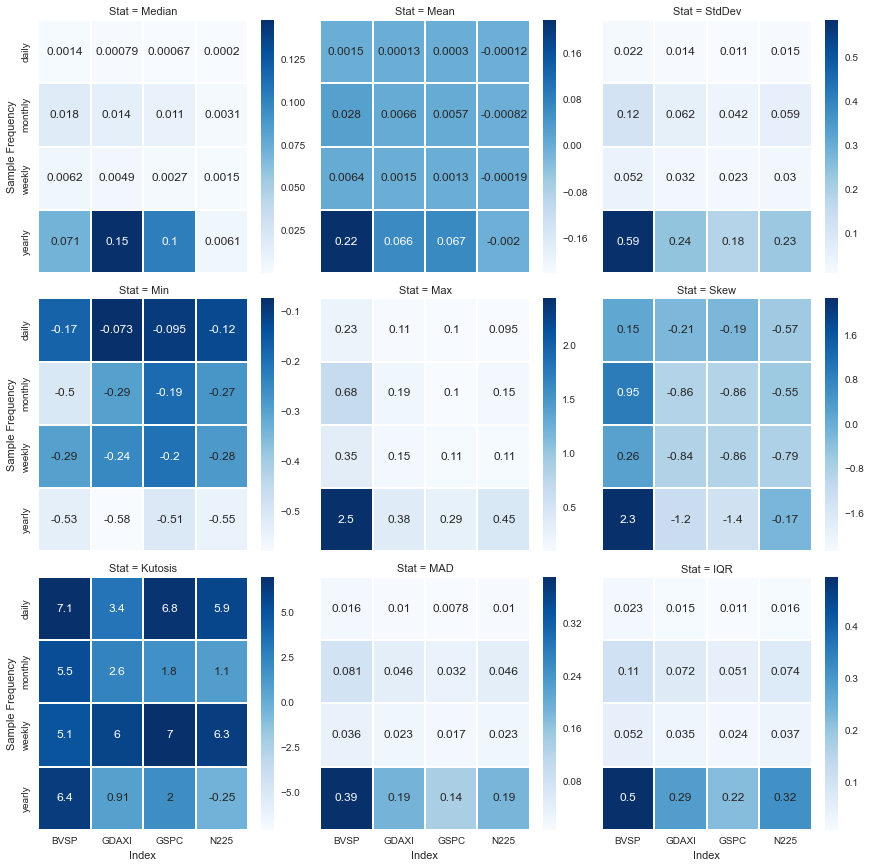

In [82]:
# arruma estrutura os dados para usar em plot
df_rtn2 = df_rtn.stack().reset_index()
df_rtn2.columns = ['Sample', 'Stat', 'Index', 'Value']
df_rtn2 = df_rtn2[df_rtn2.Stat != 'Count']

# cria funcao para fazer cada heatmap
def facet(data, color):
    data = data.pivot(index="Sample", columns='Index', values='Value')
    g = sns.heatmap(data, annot=True, linewidths=.5, cmap='Blues')

#plota o heatmap de cada estatistica
with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(df_rtn2, col="Stat", col_wrap=3, size=4, aspect=1)
    g = g.map_dataframe(facet)
    g.add_legend()
    g.set_xlabels('Index')
    g.set_ylabels('Sample Frequency')

Apesar das cores não ajudarem tanto, já que é esperado que haja um aumento nos valores de cada estatística quando aumentamos a frequência que consideramos os dados (diário para semanal, por exemplo), a disposição dos dados desta maneira ajudou a perceber algumas coisas curiosas:
- A mediana anual mais alta foi fo índice DAX
- Todas as médias do *Nikkey 225* são negativas, independente da frequência (e sua volatilidade anual não é baixa)
- O pior retorno anual de todos os Indices foi semelhante
- A assimetria de nenhuma distribuição ficou perto de 0 (zero)
- O desvio médio absoluto, no geral, é inferior ao desvio padrão

Agora, vou checar visualmente a distribuição dos retornos e sobrepor como seria a distribuição normal deles se considerasse o mesmo desvio e média. Note que os eixos X e Y tem amplitudes diferentes em cada gráfico.

In [86]:
df_plot = None
for s_name in l_name:
    df_aux = d_logrtn[s_name].copy()
    df_aux.index = [[s_name] * len(df_aux.index), df_aux.index]
    if s_frq == '1D':
        df_plot = df_aux.copy()
    else:
        df_plot = pd.concat([df_plot, df_aux])

df_plot = df_plot.stack().reset_index()
df_plot.columns = ['Freq', 'Date', 'Index', 'Return']

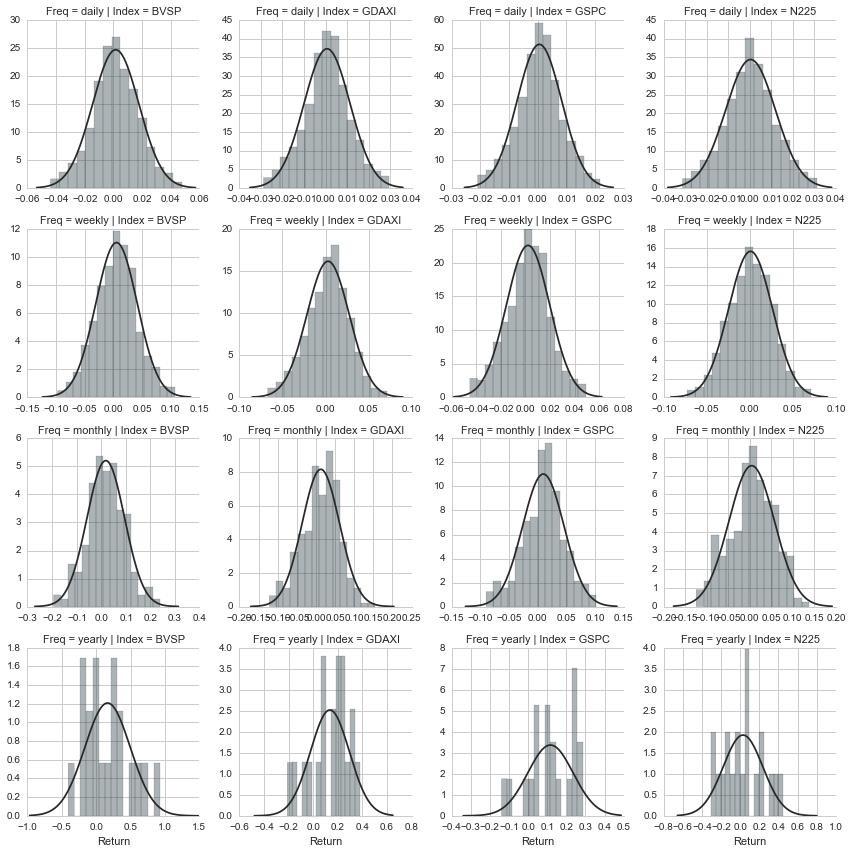

In [87]:
import matplotlib.pyplot as plt
from scipy import stats
# pltando dados sem out-liers
g = sns.FacetGrid(df_plot, col="Index",
                  row='Freq', sharex=False,
                  sharey=False)
g.map(sns.distplot, "Return", bins=15, kde=False,
      fit=stats.norm);

Para alguns dos gráficos acima, não ficou tão claro se realmente não podem ser considerados normalmente distribuídos. Abaixo, vou aplicar o teste [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque–Bera_test) para testar a normalidade das distribuições e imprimir o p-valor dos teste para cada Índice/Frequência:

In [12]:
# imprime p-values dos testes
from scipy import stats
df_jarque_bera = df_plot.groupby(['Freq', 'Index']).aggregate(stats.jarque_bera)
pd.DataFrame([[x[0][1]] for x in df_jarque_bera.values], index=df_jarque_bera.index,
             columns=['p-value'])

p-value
Freq    Index          
daily   BVSP   0.827902
        GDAXI  0.041758
        GSPC   0.029428
        N225   0.559243
monthly BVSP   0.983525
        GDAXI  0.194519
        GSPC   0.143611
        N225   0.153363
weekly  BVSP   0.998951
        GDAXI  0.011183
        GSPC   0.174028
        N225   0.117950
yearly  BVSP   0.630335
        GDAXI  0.453847
        GSPC   0.620602
        N225   0.714038

A hipótese nula é que a distribuição é normal. O teste grossamente consiste em testar se a assimetria o excesso de curtose (curtose - 3) são zero, como é esperado por uma distriibuição normal. Curiosamente, o teste não rejeitou a hipótese nula que o *S&P 500* e o *DAX* na frequência diária sejam normais e que o *DAX* seja normal na frequência semanal.


## 2 Replicação do Índice Bovespa

Nesta segunda parte o objetivo é praticar a agregação transversal de retornos financeiros através da replicação de um índice de ações. Neste caso o objetivo é a replicação do Índice Bovespa (IBOV) através dos retornos individuais das ações compõem o índice.

*Style notebook and change matplotlib defaults*

In [13]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('').read())

IOError: [Errno 2] No such file or directory: ''

In [88]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [1]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))